# Temporary disaggregation quarterly timeseries to monthly timeseries

This note explains step by step transformation of quarterly timeseries to monthly timeseries method.
This 5-step method allows to keep trend, seasonality and ensures that monthly data still averages up to quarterly data

The input to the code is timeseries in quarterly granularity.
The output of the code is timeseries with monthly granularity

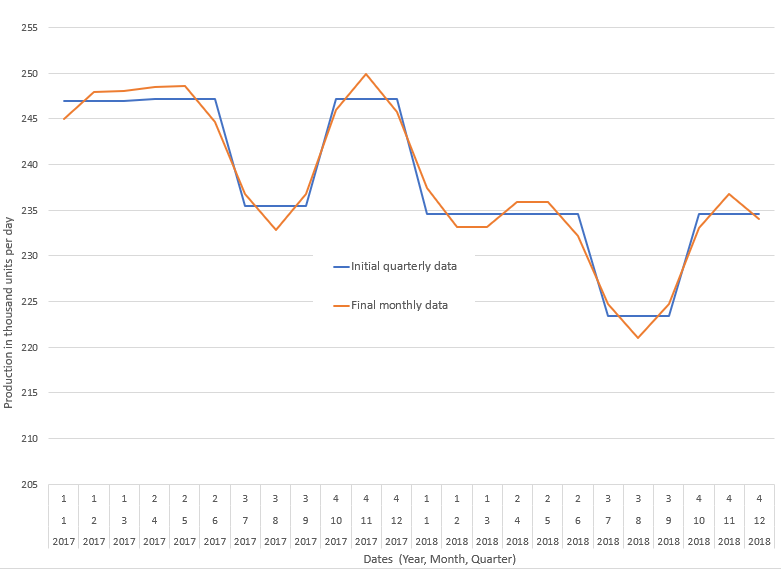

The following python packages will be required for the code to run

In [ ]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import datetime
import os
import calendar
import math

First part of the code consists of operators importing quarterly data and to write this data into specifically created monthly dataframe as many times as we have unique observations (for example, countries):

In [ ]:
# Open input_filename
df_original = pd.read_excel(path+input_filename, sheet_name = 'Sheet2', header = 0, usecols = 'F:J')

# Take copy of original frame
df = df_original.copy()

df.loc[df['Value']=='NODATA',['Value']]=0
df['Value'] = df['Value'].astype(float)
df['Country'] = df['Country'].astype(str)
df = df.loc[df['Value'] > 0]
#it is important to sort dataframe alphabetically by country, as later in the code groupby argument works alphabetically and otherwise produces wrong results
df.sort_values(by=['Country','Year','Quarter'],inplace=True)

# check how many unique countries are created, create a variable with numnber of unique countries 
Nuniquecountries=df['Country'].nunique()

#create dataframe with dates: step = one month from 1990-01-01 to 2025-12-01. 
#code for creating a dataframe:df_appended = pd.DataFrame(pd.date_range(start='1990-01-01',end='2025-12-01',freq='MS')) not used here, just for reference
#This dataframe is copied as many times over as there are number of unique countries 
#for this loop is created that goes as many times as there unique countries, then for each country copies over the entire timerange 

df_appended = pd.DataFrame()

for Country in df['Country'].unique():   
    timerange = pd.date_range(start='1990-01-01',end='2025-12-01',freq='MS').to_frame()
    timerange['Country'] = Country
    df_appended = df_appended.append(timerange)
df_appended.reset_index(inplace=True)
df_appended.drop(columns = 'index',inplace=True)

df_appended.rename(columns={df_appended.columns[0]: "Date" }, inplace = True)
df_appended['Year']=pd.to_datetime(df_appended['Date']).dt.year
df_appended['Quarter']=pd.to_datetime(df_appended['Date']).dt.quarter
df_appended['Month']=pd.to_datetime(df_appended['Date']).dt.month

df_work= pd.merge(df_appended, df, on=['Year','Quarter','Country'], how='left')
df_work.dropna(inplace=True)

Second part of the code transforms quarterly to monthly timeseries in 4 steps

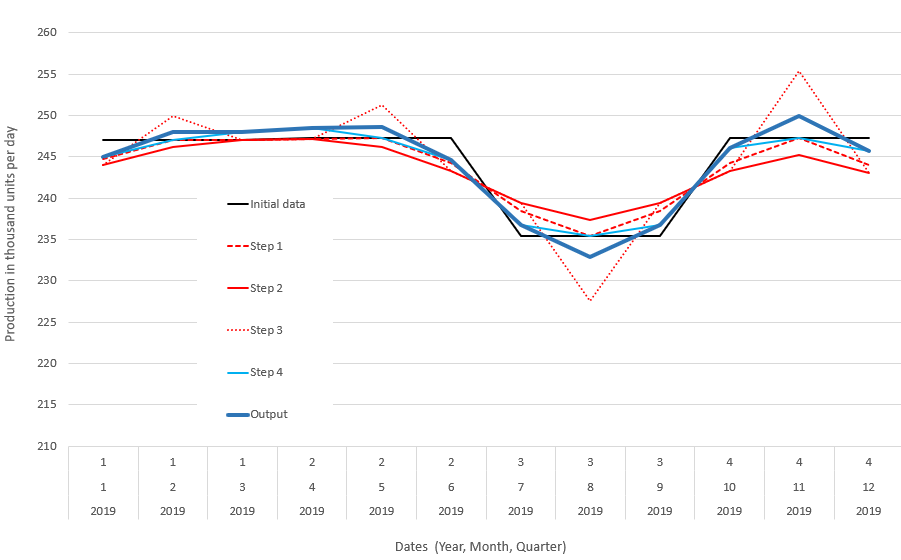

Initial data will go through the 5 following steps (transformations) before the final result is derived:

Step1: interpollation between the first month in the quarter and the last month of previous quarter as well as between the last month of the quarter with first month of the following quarter with 75%/25% weights

Step2: 3-month moving average of step 1 data

Step3: allocating the entire difference between step 2 and initial data to the central month in the quarter

Step4: 3-month moving average

Step5: allocating the entrie difference betwee step 4 and initial data to the central month in the quarter
Step 5 is the output of the code

Detailed description of the 5 abovementioned steps is below:

Step 1:

In [ ]:
#Step 1 
    #weighting last/first month in the quarter and interpolating with weights: 
    #if first month in quarter, take 75% of its value + 25% of previous months value
    #if last month in quarter, take 75% of its value + 25% of next months value
    #otherwise keep intact

#Creating parrallel previous month column
df_work['country-1']=df_work['Country'].shift(1)
#making sure that values from the next country in the list do not interfere with the values of a currect country
#if current country name still equals the country+1 country name, keep value, otherwise overwrite with 0 
df_work['value-1']=np.where((df_work['Country']==df_work['country-1']), df_work['Value'].shift(1),0).astype(float)
#Creating parrallel next month column
df_work['country+1']=df_work['Country'].shift(-1)
#making sure that values from the next country in the list do not interfere with the values of a currect country
#if current country name still equals the country+1 country name, keep value, otherwise overwrite with 0
df_work['value+1']=np.where((df_work['Country']==df_work['country+1']), df_work['Value'].shift(-1),0)

#allocating monthly weights
#if central month in quarter, then weight as 1, otherwise weight as 0.75
df_work.loc[df_work['Month'].isin([2,5,8,11])==True, 'Weight']=1
#replace nans with 0.75
where_are_Nans=np.isnan(df_work['Weight'])
df_work['Weight'][where_are_Nans]=0.75
df_work['Weight2']=0.25
df_work.reset_index()
#create weight for second variable in equation (either previous or next month)


#if first month in quarter -> value*75%+previousmonth*25%
df_work['Firstmonths']=df_work['Value']*df_work['Weight']+df_work['value-1']*df_work['Weight2']

#if last month in quarter -> value*75%+nextmonth*25%
df_work['Lastmonths']=df_work['Value']*df_work['Weight']+df_work['value+1']*df_work['Weight2']

#If central month in quarter -> keep initial value, otherwise replace by first and last month in quarter values
df_work['STEP1']=np.where((df_work['Weight']==1), df_work['Value'],0)
df_work.loc[df_work['Month'].isin([1,4,7,10])==True,'STEP1']=df_work['Firstmonths']
df_work.loc[df_work['Month'].isin([3,6,9,12])==True,'STEP1']=df_work['Lastmonths']

#Drop all not necessary columns
df_work.drop(df_work.columns[7:15], axis=1, inplace=True)

Step 2:

In [ ]:
##Step2
    #reseting index for correct 3MA computation
    #calculating 3 month moving average
    #droping N/As
df_work.reset_index(inplace=True)
df_work['STEP2_3MA']=df_work.groupby(['Country'])['STEP1'].rolling(window=3,axis=0).mean().shift(-1).reset_index(drop=True)
df_work.dropna(inplace=True)

Step 3:

In [ ]:
##Step3
    #Allocating all quarterly difference between initial Value and Step2 value to central month in a quarter
#summarizing initial quarterly values and allocating them to a separate column
df_sumvalues=df_work.groupby(['Country','Year','Quarter'])['Value'].sum().reset_index()
df_work = pd.merge(df_work, df_sumvalues, on=['Country', 'Year', 'Quarter'], how='left')
#summarizing Step2 quarterly values and allocating them to a separate column
df_sumstep2=df_work.groupby(['Country','Year','Quarter'])['STEP2_3MA'].sum().reset_index()
df_work = pd.merge(df_work, df_sumstep2, on=['Country', 'Year', 'Quarter'], how='left')
#removing x and y from the end of column names as a result of dataframes merging
df_work.rename(columns={'Value_y': 'Step3sumvalues'}, inplace=True)
df_work.rename(columns={'STEP2_3MA_y': 'Step3sum3MA'}, inplace=True)
df_work.rename(columns={'STEP2_3MA_x': 'STEP2_3MA'}, inplace=True)
df_work.rename(columns={'Value_x': 'Value'}, inplace=True)

#creating a column that allocates all quarterly difference between value and Step2 to central month in quarter. If month is not central in quarter -> value is 0
df_work['Step3diff']=np.where((df_work['Month'].isin([2,5,8,11])==True), df_work['Step3sumvalues']-df_work['Step3sum3MA'],0)
#writing Step3 values to a ceparate column and dropping unnecessary columns
df_work['STEP3']=df_work['STEP2_3MA']+df_work['Step3diff']
#Drop all not necessary columns
df_work.drop(df_work.columns[9:12], axis=1, inplace=True)

In [ ]:
Step 4:

In [ ]:
##Step4
    #reseting index for correct 3MA computation
    #calculating 3 month moving average
    #droping N/As
df_work.reset_index(inplace=True)
df_work['STEP4_3MA']=df_work.groupby(['Country'])['STEP3'].rolling(window=3,axis=0).mean().shift(-1).reset_index(drop=True)
df_work.dropna(inplace=True)

In [ ]:
Step 5:

In [ ]:
##Step5

    #Allocating all quarterly difference between initial Value and Step4 value to central month in a quarter
#summarizing initial quarterly values and allocating them to a separate column

df_sumvalues=df_work.groupby(['Country','Year','Quarter'])['Value'].sum().reset_index()
df_work = pd.merge(df_work, df_sumvalues, on=['Country', 'Year', 'Quarter'], how='left')
#summarizing Step4 quarterly values and allocating them to a separate column
df_sumstep2=df_work.groupby(['Country','Year','Quarter'])['STEP4_3MA'].sum().reset_index()
df_work = pd.merge(df_work, df_sumstep2, on=['Country', 'Year', 'Quarter'], how='left')
#removing x and y from the end of column names as a result of dataframes merging
df_work.rename(columns={'Value_y': 'Step5sumvalues'}, inplace=True)
df_work.rename(columns={'STEP4_3MA_y': 'Step5sum3MA'}, inplace=True)
df_work.rename(columns={'STEP4_3MA_x': 'STEP4_3MA'}, inplace=True)
df_work.rename(columns={'Value_x': 'Value'}, inplace=True)

#creating a column that allocates all quarterly difference between value and Step5 to central month in quarter. If month is not central in quarter -> value is 0
df_work['Step5diff']=np.where((df_work['Month'].isin([2,5,8,11])==True), df_work['Step5sumvalues']-df_work['Step5sum3MA'],0)
#writing Step5 values to a ceparate column and dropping unnecessary columns
df_work['STEP5']=df_work['STEP4_3MA']+df_work['Step5diff']
#Drop all not necessary columns
df_work.drop(df_work.columns[12:15], axis=1, inplace=True)

Writing the output into excel file and limiting timeseries to a certain period (in our case it is years 2000-2019):

In [ ]:
##writing dataframe to final output and limiting timeline to 2000<=x<=2019 
df_output = df_work[['Date','Country', 'Year', 'Month', 'Quarter', 'Value','STEP5']]
df_output.rename(columns={'STEP5':'OUTPUT'}, inplace=True)
df_output = df_output[df_output['Year']>=2000]
df_output = df_output[df_output['Year']<=2019]
